<a href="https://colab.research.google.com/github/AnnyNny/deep-learning/blob/main/segmentation_losses_hw_the_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><image src="https://drive.google.com/uc?id=1n3G4TdK_u6PQHcLrxB_A0HijNdigXmUH">

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Сегментация изображений</b></h3>


В этом задании вам предстоит решить задачу сегментации медицинских снимков. Домашнее задание можно разделить на следующие части:

* Построй свой первый бейзлайн! [6]
  * BCE Loss [2]
  * SegNet [2]
  * Train [1]
  * Test [1]
* Мир других лоссов! [2]
  * Dice Loss [1]
  * Focal Loss [1]
  * BONUS: лосс из статьи [5]
* Новая модель! [2]
  * UNet [2]


**Максимальный балл:** 10 баллов.

Также для студентов желающих еще более углубиться в задачу предлагается решить бонусное задание, которое даст дополнительные 5 баллов. BONUS задание необязательное.


# Шаг 1. Загрузка и подготовка данных

1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>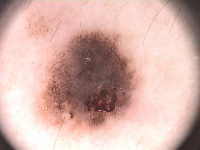</td><td>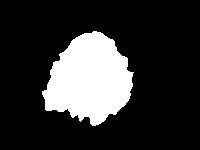</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [ ]:
import os
from skimage.io import imread

images = []
lesions = []

root = "/kaggle/input/ph2-skin-lesion-dataset/PH2Dataset/PH2 Dataset images"

for folder in os.listdir(root):
    folder_path = os.path.join(root, folder)
    if not os.path.isdir(folder_path):
        continue

    # Dermoscopic image
    for f in os.listdir(os.path.join(folder_path, folder + "_Dermoscopic_Image")):
        if f.endswith(".bmp"):
            images.append(imread(os.path.join(folder_path, folder + "_Dermoscopic_Image", f)))

    # Mask
    for f in os.listdir(os.path.join(folder_path, folder + "_lesion")):
        if f.endswith(".bmp"):
            lesions.append(imread(os.path.join(folder_path, folder + "_lesion", f)))


Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [ ]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [ ]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

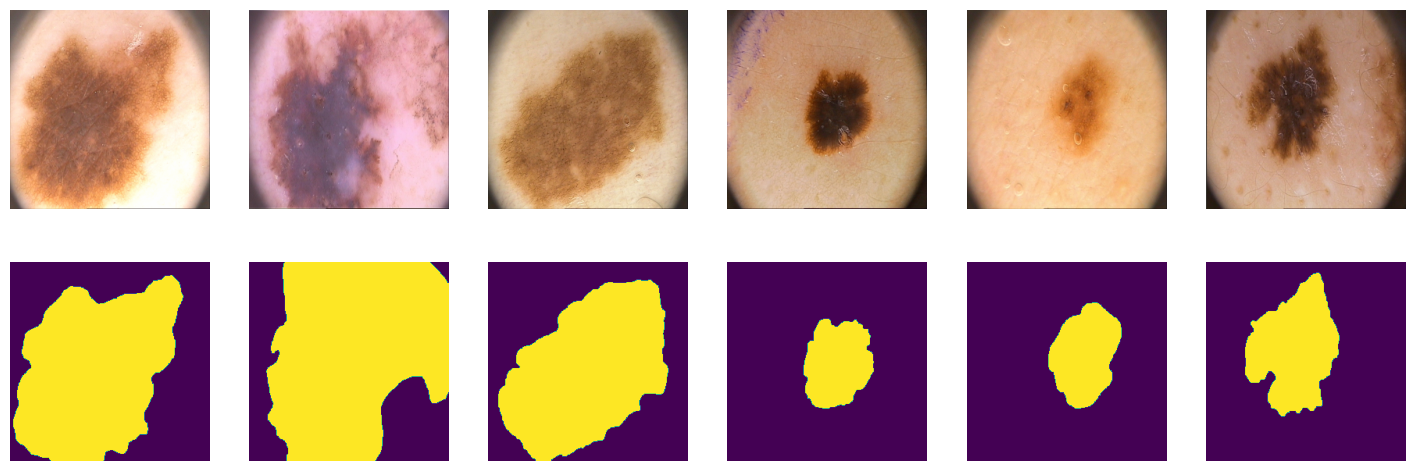

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [ ]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [ ]:
print(len(tr), len(val), len(ts))

100 50 50


## PyTorch DataLoader

In [ ]:
from torch.utils.data import DataLoader
#batch_size = 25
batch_size = 4
train_dataloader = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])),
                     batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=False)

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Шаг 2. Метрика качества модели

## IoU (intersection over union)

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Что будет являться пересением и объединением в задаче сегментации?

Давайте разберем следующий пример:





<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1rBYFgli48AUUN9idiyq8j3J5DboB93yN" width=1000 height=800/></p>

In [ ]:
!pip install torchmetrics

In [ ]:
from torchmetrics import JaccardIndex

iou_score = JaccardIndex(threshold=0.5, task="binary", average='none').to(device)

# Задания: Построй свой первый бейзлайн!

Итак, загрузка файлов, код датасета и даталоадера написана за вас. Метрика IoU написана за вас! Вам остается написать лосс, модель и функции обучения и теста модели.

* Построй свой первый бейзлайн! [6]
  * BCE Loss [2]
  * SegNet [2]
  * Train [1]
  * Test [1]

## Шаг 3. Loss функция - BCE [2 балла]

Популярным лоссом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right] \space [1]$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right) \space [2]$$

### Вывод численно стабильной формулы BCE лосса [1 балл]



Выведите из формулы [1] формулу [2]:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right] \space [1]$$

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right) \space [2]$$

Не забываем, что здесь $\hat y_i$ - это логиты сети, не вероятности и не лейблы.

**Ответ:**

### Реализуйте в коде оба варианта лосса [1 балл]

Реализуйте следующие функции:

*   `bce_true()` - честная прямая реализация лосса с формулой $$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$
*   `bce_loss()` - реализация формулы, которую мы вывели $$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

И сравните результаты функций с реализацией Pytorch:
*   `bce_torch()`
*   `bce_torch_with_logits()`

In [ ]:
import torch.nn.functional as F
import torch.nn as nn
from torch import log, exp, sigmoid
import torch

In [ ]:
bce_torch = nn.BCELoss(reduction='sum') # (sigmoid(y_pred), y_real)
bce_torch_with_logits = nn.BCEWithLogitsLoss(reduction='sum')

In [ ]:
def bce_loss(y_pred, y_real):
  bce_loss = y_real*torch.log(torch.sigmoid(y_pred)) + (1-y_real)*torch.log(1-torch.sigmoid(y_pred))
  sum_loss = torch.sum(bce_loss)*-1
  return sum_loss

def bce_true(y_pred, y_real):
  bce_true = y_pred - y_pred*y_real + torch.log(1+(torch.exp(-y_pred)))
  sum = torch.sum(bce_true)
  return sum

Проверим корректность работы на простом примере

In [ ]:
y_pred = torch.randn(3, 2, requires_grad=False)
y_true = torch.rand(3, 2, requires_grad=False)

print(f'BCE loss from scratch bce_loss             = {bce_loss(y_pred, y_true)}')
print(f'BCE loss честно посчитанный                = {bce_true(y_pred, y_true)}')
print(f'BCE loss from torch bce_torch              = {bce_torch(torch.sigmoid(y_pred), y_true)}')
print(f'BCE loss from torch with logits bce_torch  = {bce_torch_with_logits(y_pred, y_true)}')


BCE loss from scratch bce_loss             = 4.744635581970215
BCE loss честно посчитанный                = 4.744636058807373
BCE loss from torch bce_torch              = 4.744635581970215
BCE loss from torch with logits bce_torch  = 4.744635581970215


Инструкции `assert` в Python — это булевы выражения, которые проверяют, является ли условие истинным (`True`). Внизу в коде мы проверяем функция `bce_loss()` выдает тот же результат, что и функция из Pytorch или нет. Если равенства не будет, что будет означать, что результаты функций не совпадают, а значит вы неправильно реализовали фукнцию `bce_loss()`, `assert` возвратит ошибку.

Функция `numpy.isclose()` используется для сравнения двух чисел с учётом допустимой погрешности. Она особенно полезна при работе с числами с плавающей точкой, где точное сравнение может быть проблематичным из-за ограничений представления таких чисел в компьютере.

Как она работает?

`numpy.isclose(a, b, rtol=1e-05, atol=1e-08) `принимает два числа (`a` и `b`) и сравнивает их, учитывая относительную и абсолютную погрешность. Если разница между двумя числами меньше заданного порога, функция возвращает `True`, иначе — `False`.

Параметры:

    rtol: Относительная погрешность (по умолчанию 1e-05). Используется для определения разницы относительно большего значения.
    atol: Абсолютная погрешность (по умолчанию 1e-08). Определяет минимальную разницу, которую следует учитывать.

Мы будем использовать `assert` и `numpy.isclose()` для проверки корректности нашего кода.

In [ ]:
import numpy as np

In [ ]:
assert np.isclose(bce_loss(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true))
assert np.isclose(bce_loss(y_pred, y_true), bce_torch_with_logits(y_pred, y_true))
assert np.isclose(bce_true(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true))
assert np.isclose(bce_true(y_pred, y_true), bce_torch_with_logits(y_pred, y_true))

Давайте теперь посчитаем на простом примере, но с теми же размерностями, что и в датасете

In [ ]:
y_pred = torch.randn((2, 1, 3, 3), requires_grad=False)
y_true = torch.randint(0, 2, (2, 1, 3, 3))

print(f'BCE loss from scratch bce_loss            = {bce_loss(y_pred, y_true)}')
print(f'BCE loss честно посчитанный               = {bce_true(y_pred, y_true)}')
print(f'BCE loss from torch bce_torch             = {bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float))}')
print(f'BCE loss from torch with logits bce_torch = {bce_torch_with_logits(y_pred, y_true.to(torch.float))}')

BCE loss from scratch bce_loss            = 12.092893600463867
BCE loss честно посчитанный               = 12.09289264678955
BCE loss from torch bce_torch             = 12.092893600463867
BCE loss from torch with logits bce_torch = 12.09289264678955


In [ ]:
assert np.isclose(bce_loss(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float)))
assert np.isclose(bce_loss(y_pred, y_true), bce_torch_with_logits(y_pred, y_true.to(torch.float)))
assert np.isclose(bce_true(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float)))
assert np.isclose(bce_true(y_pred, y_true), bce_torch_with_logits(y_pred, y_true.to(torch.float)))

Давайте посчитаем на реальных логитах и сегментационной маске:

In [ ]:
!gdown --folder 1EX0RW1TRQVkLmR1h6miCQqyhYPFyg28M

Retrieving folder contents
Processing file 1--WxvBdpMn_NOmYPf3a4au8MHzfx5baC labels.pt
Processing file 1-0A7_CS_vKiSCkgIDJ4joThCEcFedA3I logits.pt
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1--WxvBdpMn_NOmYPf3a4au8MHzfx5baC
To: /kaggle/working/for_asserts/labels.pt
100%|██████████████████████████████████████| 1.18k/1.18k [00:00<00:00, 5.80MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-0A7_CS_vKiSCkgIDJ4joThCEcFedA3I
To: /kaggle/working/for_asserts/logits.pt
100%|██████████████████████████████████████| 1.18k/1.18k [00:00<00:00, 6.94MB/s]
Download completed


In [ ]:
path_to_dummy_samples = '/kaggle/working/for_asserts'
dummpy_sample = {'logits': torch.load(f'{path_to_dummy_samples}/logits.pt'),
                 'labels': torch.load(f'{path_to_dummy_samples}/labels.pt')}
dummpy_sample['labels'] = dummpy_sample['labels'].to(device)
dummpy_sample['logits'] = dummpy_sample['logits'].to(device)

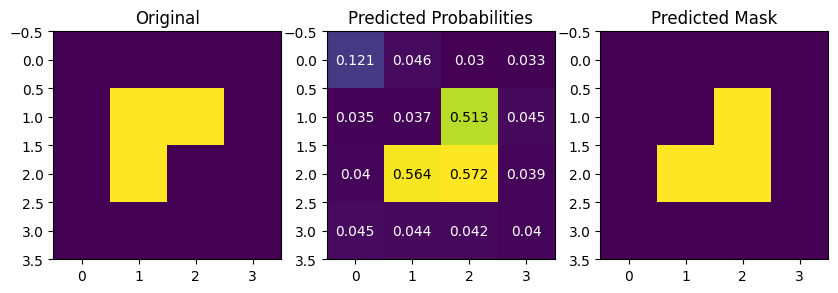

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize= (10,3*10))

ax1.imshow(dummpy_sample['labels'].squeeze(1)[0].cpu())
ax1.set_title("Original")

ax2.imshow(dummpy_sample['logits'].sigmoid().squeeze(1)[0].cpu())
for (j,i),label in np.ndenumerate(dummpy_sample['logits'].sigmoid().squeeze(1)[0].cpu()):
    if label < 0.5:
        color = 'white'
    else:
        color = 'black'
    ax2.text(i,j,round(label,3), color=color, ha='center',va='center')

ax2.set_title("Predicted Probabilities")

ax3.imshow((dummpy_sample['logits'].sigmoid() > 0.5).squeeze(1)[0].cpu())
ax3.set_title("Predicted Mask")
plt.show()

Проверяем на данном примере:

In [ ]:
bce_loss_score = bce_loss(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu())
bce_true_score = bce_true(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu())
bce_torch_score = bce_torch(torch.sigmoid(dummpy_sample['logits'].cpu()), dummpy_sample['labels'].cpu().float())
bce_torch_with_logits_score = bce_torch_with_logits(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu().float())
assert np.isclose(bce_loss_score, bce_torch_score)
assert np.isclose(bce_loss_score, bce_torch_with_logits_score)
assert np.isclose(bce_true_score, bce_torch_score)
assert np.isclose(bce_true_score, bce_torch_with_logits_score)

## Шаг 4. Модель SegNet [2 балла]

Ваше задание здесь состоит в том, чтобы реализовать SegNet архитектуру.

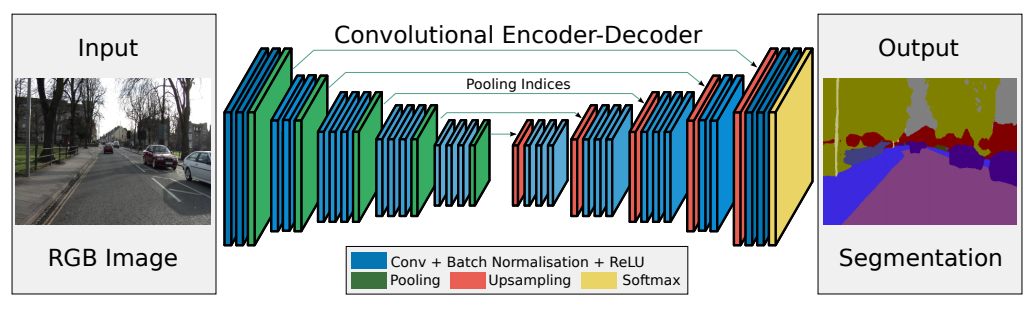

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки. Для этого скачаем и изучим feature extractor VGG-16, который лежит в основе SegNet.

In [ ]:
model_vgg16 = models.vgg16(weights = models.VGG16_Weights.IMAGENET1K_V1)

In [ ]:
model_vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Feature extractor VGG-16 состоит из 5 блоков:
- два блока со структурой:
Conv2d -> ReLU -> Conv2d -> ReLU -> MaxPool2d
- три блока со структурой:
Conv2d -> ReLU -> Conv2d -> ReLU -> Conv2d -> ReLU -> MaxPool2d

В первом блоке - на входе три канала (по числу каналов в изображениях), которые конволюционный слой преобразует в 64 канала.

Во втором, третьем и четвертом блоках первый конволюционный слой удваивает количество каналов, а последующие конволюционные слои не меняют количество каналов.

В последнем блоке число каналов от слоя к слою не меняется.

Теперь напишем код одного блока энкодера нашей модели SegNet.  

In [ ]:
# Параметрами блока будут:
# - количество каналов на входе
# - количество каналов на выходе
# - глубина блока (2 или 3, по количеству конволюционных слоев)
# - kernel_size и padding
#
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, depth, kernel_size = 3, padding = 1):
        super(EncoderBlock, self).__init__() # инициируем экземляр класса, наследующего от nn.Module
        self.layers = nn.ModuleList() # в self.layers будем добавлять слои блока
        # дальше реализуем то, что на картинке выше обозначено Conv + Batch Normalization + ReLU
        self.layers.append(nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = kernel_size, padding = padding))
        self.layers.append(nn.BatchNorm2d(out_channels))
        self.layers.append(nn.ReLU(inplace=True))

        # цикл for помогает использовать один код для блоков как с глубиной 2, так и с глубиной 3
        for i in range(depth-1):
            self.layers.append(nn.Conv2d(in_channels = out_channels, out_channels = out_channels, kernel_size = kernel_size, padding = padding))
            self.layers.append(nn.BatchNorm2d(out_channels))
            self.layers.append(nn.ReLU(inplace=True))

        self.maxpooling = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # pooling

    # Обратите внимание: на вход метод forward() получает карту признаков (х),
    # а возвращает карту признаков и индексы для последующего Unpooling
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x, indices = self.maxpooling(x)
        return x, indices


По аналогии напишите код одного блока декодера.

К карте признаков на входе каждого блока примеяется nn.MaxUnpool2d с индексами из симметричного блока энкодера. Затем повторяется связка Conv + Batch Normalization + ReLU. Количество каналов меняется зеркально блокам энкодера:
- в первом блоке декодера количество каналов не меняется
- во 2-4 блоках декодера количество каналов уменьшается в 2 раза после прохождения последнего конволюционного слоя
- на выходе из последнего блока декодера 1 канал

Обратите внимание, что после последней конволюции последнего блока декодера не применяется батч-нормализация и функция активации.

In [ ]:
class DecoderBlock(nn.Module):
  def __init__(self, in_channels, out_channels, depth, kernel_size = 3, padding = 1) -> None:
      super(DecoderBlock, self).__init__()
      self.layers = nn.ModuleList() # в self.layers будем добавлять слои блока
      self.unpooling = nn.MaxUnpool2d(kernel_size=2, stride=2)
      # дальше реализуем то, что на картинке выше обозначено Conv + Batch Normalization + ReLU
      self.layers.append(nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = kernel_size, padding = padding))
      self.layers.append(nn.BatchNorm2d(out_channels))
      self.layers.append(nn.ReLU(inplace=True))

      # цикл for помогает использовать один код для блоков как с глубиной 2, так и с глубиной 3
      for i in range(depth-1):
          self.layers.append(nn.Conv2d(in_channels = out_channels, out_channels = out_channels, kernel_size = kernel_size, padding = padding))
          self.layers.append(nn.BatchNorm2d(out_channels))
          self.layers.append(nn.ReLU(inplace=True))

  def forward(self,x,indices):
    x = self.unpooling(x, indices)
    for layer in self.layers:
      x = layer(x)
    return x

Соединим блоки энкодера и декодера в модель SegNet:

In [ ]:
class SegNet(nn.Module):
    def __init__(self, in_channels=3, out_channels = 1, num_features = 64) -> None:
        super(SegNet, self).__init__()

        # Encoder
        self.encoder0 = EncoderBlock(in_channels, num_features, depth=2)
        self.encoder1 = EncoderBlock(num_features, num_features * 2, depth=2)
        self.encoder2 = EncoderBlock(num_features*2, num_features*4,depth=3)# TODO
        self.encoder3 = EncoderBlock(num_features*4, num_features*8, depth=3)# TODO

        # Encoder bottleneck - количество каналов на входе и на выходе одинаково
        self.encoder4 = EncoderBlock(num_features*8, num_features*8, depth=3)# TODO

        # Decoder bottleneck
        self.decoder0 = DecoderBlock(num_features*8, num_features*8, depth=3)# TODO

        # Decoder
        self.decoder1 = DecoderBlock(num_features*8, num_features*4, depth=3)
        self.decoder2 = DecoderBlock(num_features*4, num_features*2, depth=2)
        self.decoder3 = DecoderBlock(num_features*2, num_features, depth=2)
        self.decoder4 = DecoderBlock(num_features, out_channels, depth=2)

    def forward(self, x):
        # encoder
        x, indices0 = self.encoder0(x)
        x, indices1 = self.encoder1(x)
        x, indices2 = self.encoder2(x)
        x, indices3 = self.encoder3(x)
        x, indices4 = self.encoder4(x)# TODO
        # TODO
        x = self.decoder0(x, indices4)
        x = self.decoder1(x, indices3)
        x = self.decoder2(x, indices2)
        x = self.decoder3(x, indices1)
        output = self.decoder4(x, indices0)
        return output  # no activation

## Шаг 5. Тренировка модели [1 балл]

Напишите функции для обучения модели.

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
def train(model, opt, loss_fn, epochs, train_loader, val_loader, device,
          checkpoint_path="best_model.pth", patience=5):

    model.to(device)
    best_val_loss = float("inf")

    train_losses = []
    val_losses = []

    no_improve_count = 0   # early stopping counter

    for epoch in range(1, epochs+1):
        print(f"\n Epoch {epoch}/{epochs}")

        # TRAIN
        model.train()
        running_loss = 0.0

        for X_batch, Y_batch in tqdm(train_loader, desc=f"Training Epoch {epoch}"):

            X_batch = X_batch.float().to(device)
            Y_batch = Y_batch.float().to(device)

            opt.zero_grad()
            Y_pred = model(X_batch)
            loss = loss_fn(Y_pred, Y_batch)

            loss.backward()
            opt.step()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        print(f"Train loss: {avg_train_loss:.4f}")

        # VALIDATION
        model.eval()
        with torch.no_grad():
            X_val, Y_val = next(iter(val_loader))
            X_val = X_val.float().to(device)
            Y_val = Y_val.float().to(device)
            Y_pred = model(X_val)

            val_loss = loss_fn(Y_pred, Y_val).item()

        val_losses.append(val_loss)
        print(f"Val loss: {val_loss:.4f}")

        # CHECK IMPROVEMENT
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            no_improve_count = 0  # reset patience counter

            torch.save(model.state_dict(), checkpoint_path)
            print(f"new best model saved (loss={best_val_loss:.4f})")

        else:
            no_improve_count += 1
            print(f"no improvement ({no_improve_count}/{patience})")

            if no_improve_count >= patience:
                print(f"\nearly stopping after {epoch} epochs.")
                break

    return train_losses, val_losses


In [ ]:
import torch.nn as nn

In [ ]:
model_segnet = SegNet()
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_segnet.parameters(), lr=1e-4)

Обучите модель **SegNet**. В качестве оптимайзера можно взять Adam.

In [ ]:
print("CUDA available:", torch.cuda.is_available())
print("GPU name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")


CUDA available: True
GPU name: Tesla T4



 Epoch 1/10


Training Epoch 1:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.6823
Val loss: 0.6931
new best model saved (loss=0.6931)

 Epoch 2/10


Training Epoch 2:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.6451
Val loss: 0.6803
new best model saved (loss=0.6803)

 Epoch 3/10


Training Epoch 3:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.6232
Val loss: 0.6423
new best model saved (loss=0.6423)

 Epoch 4/10


Training Epoch 4:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.6072
Val loss: 0.6217
new best model saved (loss=0.6217)

 Epoch 5/10


Training Epoch 5:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.6010
Val loss: 0.5586
new best model saved (loss=0.5586)

 Epoch 6/10


Training Epoch 6:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.5975
Val loss: 0.6403
no improvement (1/5)

 Epoch 7/10


Training Epoch 7:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.5923
Val loss: 0.6061
no improvement (2/5)

 Epoch 8/10


Training Epoch 8:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.5944
Val loss: 0.5822
no improvement (3/5)

 Epoch 9/10


Training Epoch 9:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.5905
Val loss: 0.5722
no improvement (4/5)

 Epoch 10/10


Training Epoch 10:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.5987
Val loss: 0.5879
no improvement (5/5)

early stopping after 10 epochs.


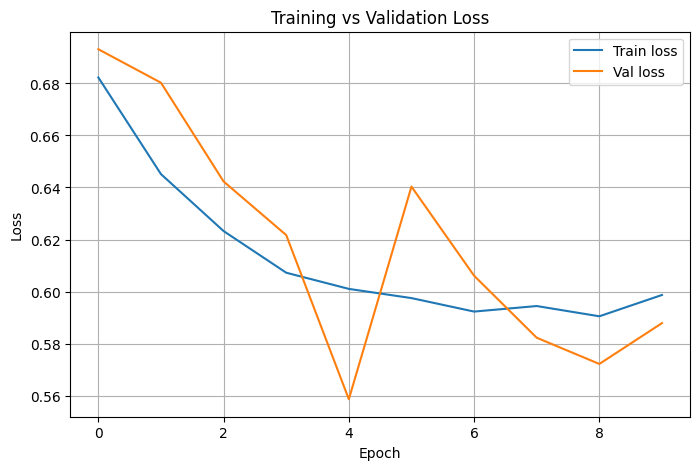

In [ ]:
# TODO
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_losses, val_losses = train(model=model_segnet, opt=optimizer, loss_fn=loss_fn, epochs=10, train_loader=train_dataloader, val_loader=valid_dataloader, device=device)

plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train loss")
plt.plot(val_losses, label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.grid(True)
plt.show()


## Шаг 6. Инференс [1 балл]

После обучения модели напишите функцию теста, воспользуйтесь лучшим чекпоинтом и протестируйте работу модели на тестовой выборке.

In [ ]:
def load_checkpoint(model, checkpoint_path, device):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint)
    model.to(device)
    model.eval()
    print("Checkpoint loaded.")
    return model


In [ ]:
model = load_checkpoint(model_segnet, "best_model.pth", device)

Checkpoint loaded.


In [ ]:
def test(model, val_loader, loss_fn, device, threshold=0.5):
    model.eval()

    preds = []
    inputs = []
    test_losses = []

    with torch.no_grad():
        for X_batch, Y_batch in val_loader:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            logits = model(X_batch)
            prob = torch.sigmoid(logits)
            pred = (prob > threshold).float()


            loss = loss_fn(logits, Y_batch)
            test_losses.append(loss.item())

            preds.append(pred.cpu().numpy())
            inputs.append(X_batch.cpu().numpy())

    avg_test_loss = np.mean(test_losses)

    return inputs, preds, avg_test_loss


In [ ]:
def visualize_val_predictions(inputs, preds, n=6):
    # flatten batches
    flat_inputs = [img for batch in inputs for img in batch]
    flat_preds  = [p   for batch in preds  for p   in batch]

    fig, axes = plt.subplots(2, n, figsize=(4*n, 8))

    for i in range(n):
        img = np.rollaxis(flat_inputs[i], 0, 3)
        mask = flat_preds[i][0]

        axes[0, i].imshow(img)
        axes[0, i].set_title("Input")
        axes[0, i].axis("off")

        axes[1, i].imshow(mask, cmap="gray")
        axes[1, i].set_title("Prediction")
        axes[1, i].axis("off")

    plt.show()


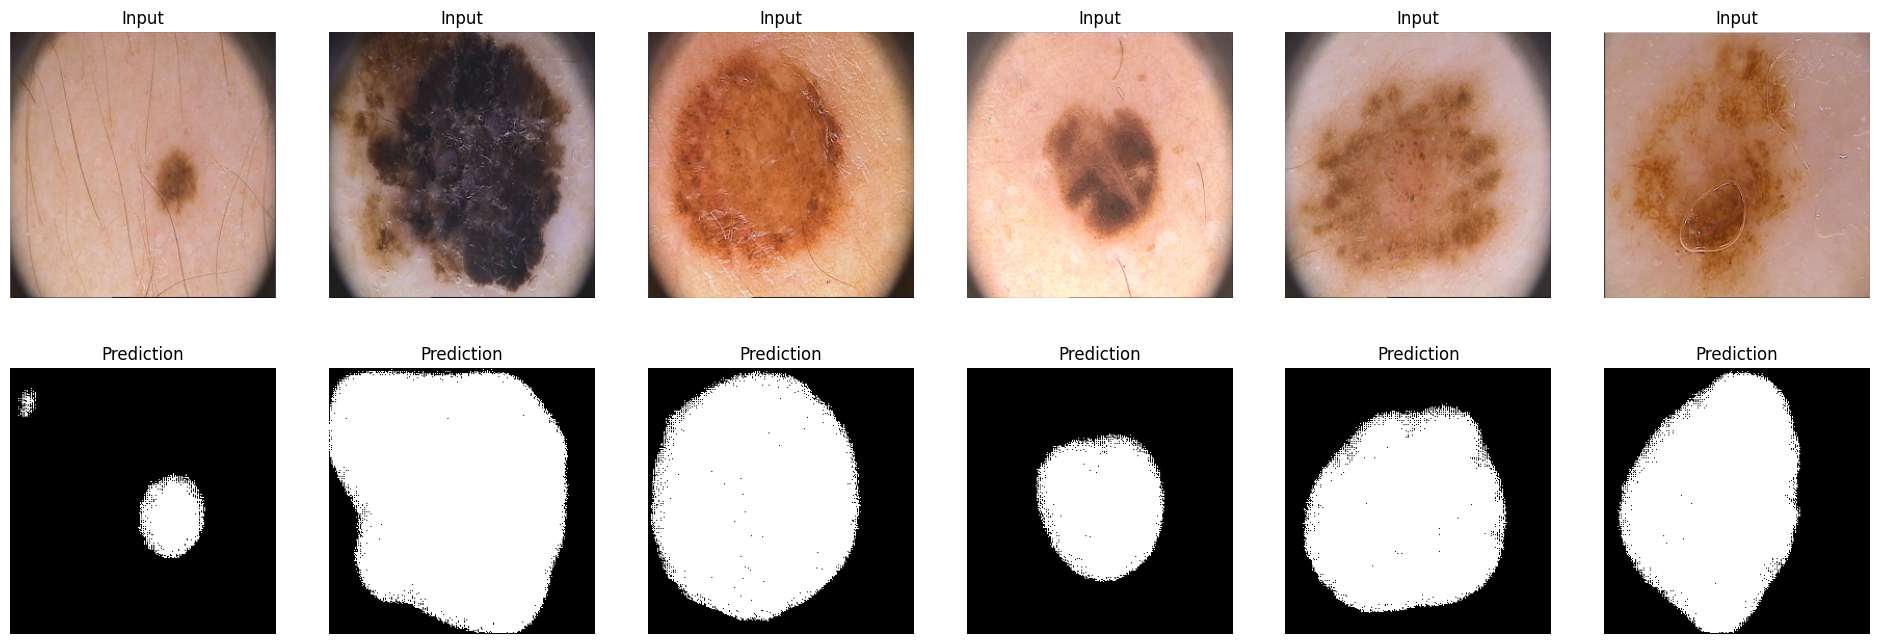

In [ ]:
# инференс на val_loader
inputs, preds, test_loss = test(model, test_dataloader,loss_fn, device)

# показать примеры
visualize_val_predictions(inputs, preds, n=6)

In [ ]:
test_loss

0.6035079405857966

# Задания: Мир других лоссов!

## Пробуем другие функции потерь [2 балла]

В данном разделе вам потребуется имплементировать две функции потерь: DICE и Focal loss.


### Dice Loss

**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

В терминах матрицы ошибок она будет считаться следующим образом:

$$D(X,Y) = \frac{2TP}{2TP + FP + FN}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1- D(X, Y)$$

**Hints** (!):

1. Не забудьте подумать о численной нестабильности, возникающей в математической формуле при ситуации, когда $\frac{0}{0}$, т.е. вам нужно добавить очень маленькое число, например $\epsilon = 1e^{-8}$, в обе части дроби при подсчете $D(X,Y)$:

$$D(X,Y) = \frac{2TP + ϵ}{2TP + FP + FN + ϵ}$$

2. Dice метрика(!), не лосс, считается похожим образом как IoU:

    2.1. На вход вам приходят logits, т.е. значения от $-∞$ до $∞$. Их переводим в вероятности от 0 до 1 при помощи функции Sigmoid.

    2.2. Фиксируем порог, например threshold=0.5, и всему что ниже порога ставим значение 0, всему что выше 1. Получаем предсказанную маску из 0 и 1.

    2.3. Считаем TP, FP, FN

    2.4. Считаем DICE метрику по формуле

Вы можете прописать для себя функцию `dice_score()` и сравнить с результатами работы функции из библиотеки `torchmetrics`.

3. Но с метрикой есть проблема, что она не дифференцируема, и если вы захотите просто взять и прописать `dice_loss` = 1 - `dice_score`, Pytorch поругается на вас и скажет, что это недифференцируемая метрика. Чтобы посчитать dice_loss делаем следующие шаги:

    3.1. На вход вам приходят logits, т.е. значения от $-∞$ до $∞$. Их переводим в вероятности от 0 до 1 при помощи функции Sigmoid.

    3.2. Здесь нам уже не нужно фиксировать порог, мы просто работаем с вероятностями. Значения вероятностей дифференцируемы и через них будут протекать градиенты.

    3.3. Считаем TP, FP, FN также как и в Dice метрике, только вместо маски, подаем вероятности.

    3.4. Считаем DICE метрику по формуле

    3.5. Считаем лосс как Loss = 1 - DICE

Итак, давайте сначала пропишем dice_score.

In [ ]:
def dice_score(logits: torch.Tensor, labels: torch.Tensor, threshold: float = 0.5):
    '''
    Это именно метрика, не лосс.
    '''
    eps = 1e-8
    pred = torch.sigmoid(logits)
    y_hat = torch.where(pred > threshold, 1.0, 0.0)
    tp = torch.sum(y_hat * labels)
    fn = torch.sum(labels) - tp
    fp = torch.sum(y_hat) - tp
    score = (2*tp + eps) / (2*tp+fp+fn+eps)

    return score

Проверим на корректность функцию dice_score:

In [ ]:
from torchmetrics.segmentation import DiceScore

dice = DiceScore(num_classes=1, average='micro').to(device)
dice(dummpy_sample['logits'].sigmoid(), dummpy_sample['labels'].to(int))

/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: DiceScore metric currently defaults to `average=micro`, but will change to`average=macro` in the v1.9 release. If you've explicitly set this parameter, you can ignore this warning.
  warnings.warn(*args, **kwargs)


tensor(0.3158, device='cuda:0')

In [ ]:
'''
если вы используете версию библиотеки 0.11.4, то можно взять torchmetrics.classification.Dice():

from torchmetrics.classification import Dice

dice = Dice(average='micro').to(device)

'''

"\nесли вы используете версию библиотеки 0.11.4, то можно взять torchmetrics.classification.Dice():\n\nfrom torchmetrics.classification import Dice\n\ndice = Dice(average='micro').to(device)\n\n"

In [ ]:
sc = dice_score(dummpy_sample['logits'], dummpy_sample['labels'])
sc

tensor(0.6667, device='cuda:0')

In [ ]:
assert dice(dummpy_sample['logits'].sigmoid()>0.5, dummpy_sample['labels'].to(int)) == dice_score(dummpy_sample['logits'], dummpy_sample['labels'])

Давайте теперь пропишем лосс и воспользуемся библиотекой `segmentation-models-pytorch`, чтобы убедиться в корректности нашей функции.

In [ ]:
def dice_loss(logits: torch.Tensor, labels: torch.Tensor):

    '''
    Это лосс.
    '''
    # TODO
    eps = 1e-8
    y_hat = torch.sigmoid(logits)
    tp = torch.sum(y_hat * labels)
    fn = torch.sum(labels) - tp
    fp = torch.sum(y_hat) - tp
    dice_score = (2*tp + eps) / (2*tp+fp+fn+eps)
    loss = 1 - dice_score

    return loss

Проверка на корректность:

In [ ]:
# проверьте, что у вас установлена библиотека
!pip install segmentation-models-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 4.0 MB/s eta 0:00:0000:01


In [ ]:
from segmentation_models_pytorch.losses import DiceLoss
dice_loss_torch = DiceLoss(mode='binary')
dice_loss_torch(dummpy_sample['logits'], dummpy_sample['labels'])

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

tensor(0.5756, device='cuda:0')

In [ ]:
assert dice_loss_torch(dummpy_sample['logits'], dummpy_sample['labels'].to(int)) == dice_loss(dummpy_sample['logits'], dummpy_sample['labels'])

### Focal Loss

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf)

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.


Из оригинальной статьи по [Focal Loss](https://arxiv.org/pdf/1708.02002.pdf):

$$p_t = \sigma(\hat y_i)y_i + (1 - \sigma(\hat y_i)) (1-y_i)$$

$$\mathcal L_{focal}(y, \hat y) = (1 - p_t)^{\gamma} \mathcal L_{BCE}(y_i, \hat y_i).$$

$$\mathcal L_{focal}(y, \hat y) = -\sum_i (1 - p_t)^{\gamma} \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

$$\mathcal L_{focal}(y, \hat y) = -\sum_i (1 - (\sigma(\hat y_i)y_i + (1 - \sigma(\hat y_i)) (1-y_i)))^{\gamma} \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

In [ ]:
def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):
    # TODO
    p = torch.sigmoid(y_pred)*y_real + (1-torch.sigmoid(y_pred))*(1-y_real)
    loss = torch.sum(((1-p)**gamma)*(y_pred-y_real*y_pred+log(1+torch.exp(-y_pred)+eps))).float()
    return loss

Проверка корректности функции:

In [ ]:
from torchvision.ops import sigmoid_focal_loss
sigmoid_focal_loss(dummpy_sample['logits'], dummpy_sample['labels'], alpha=-1, gamma=2, reduction='sum')

tensor(3.6161, device='cuda:0')

In [ ]:
focal_loss(dummpy_sample['labels'], dummpy_sample['logits'], gamma=2.0)

tensor(3.6161, device='cuda:0')

сравним оператором torch.all_close

In [ ]:
"""assert sigmoid_focal_loss(dummpy_sample['logits'], dummpy_sample['labels'], alpha=-1, gamma=2, reduction='sum') == focal_loss(dummpy_sample['labels'], dummpy_sample['logits'], gamma=2.0)"""

assert torch.allclose(sigmoid_focal_loss(dummpy_sample['logits'], dummpy_sample['labels'], alpha=-1, gamma=2, reduction='sum'),
                      focal_loss(dummpy_sample['labels'], dummpy_sample['logits'], gamma=2.0),
                      rtol=1e-5,
                      atol=1e-8)

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее, и провести численное сравнение с предыдущими функциями.

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

In [ ]:
def tversky_loss(y_pred, y_true, alpha=0.3, beta=0.7, eps=1e-8):
  y_pred = torch.sigmoid(y_pred) # logits to probabilities
  tp = torch.sum(y_pred*y_true)
  fn = torch.sum(y_true) - tp
  fp = torch.sum(y_pred) - tp
  metric = (tp + eps) / (tp + alpha*fn + beta*fp + eps)
  loss = 1 - metric
  return loss

In [ ]:
y_pred = torch.randn(3, 2, requires_grad=False)
y_true = torch.rand(3, 2, requires_grad=False)

print(f'BCE loss from scratch bce_loss             = {bce_loss(y_pred, y_true)}')
print(f'BCE loss честно посчитанный                = {bce_true(y_pred, y_true)}')
print(f'BCE loss from torch bce_torch              = {bce_torch(torch.sigmoid(y_pred), y_true)}')
print(f'BCE loss from torch with logits bce_torch  = {bce_torch_with_logits(y_pred, y_true)}')
print(f'BCE loss from scratch dice_loss             = {dice_loss(y_pred, y_true)}')
print(f'BCE loss from scratch tversky_loss parameters   0.5 0.5          = {tversky_loss(y_pred, y_true, 0.5, 0.5)}')
print(f'BCE loss from scratch tversky_loss             = {tversky_loss(y_pred, y_true)}')


BCE loss from scratch bce_loss             = 4.116400241851807
BCE loss честно посчитанный                = 4.116400241851807
BCE loss from torch bce_torch              = 4.116400718688965
BCE loss from torch with logits bce_torch  = 4.116400241851807
BCE loss from scratch dice_loss             = 0.6551424860954285
BCE loss from scratch tversky_loss parameters   0.5 0.5          = 0.6551424860954285
BCE loss from scratch tversky_loss             = 0.6728006601333618


как мы видим, Тверски и Dice loss одинаковы при значениях гиперпаарметров альфа и бета равные 0.5, в этом можно убедиться, умножив dice loss на них же

## Обучите SegNet на новых лоссах

**Задание**: обучите SegNet на новых лоссах и сравните все три лосса:
*   При каком лоссе модель сходится быстрее?
*   При каком лоссе модель выдает наилучшую метрику?

Напишите развернутый ответ на вопросы.



In [ ]:
import random

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # to ensure full determinism
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [ ]:
set_seed(42)
base_model = SegNet()
base_state = base_model.state_dict()

In [ ]:
model_bce = SegNet()
model_bce.load_state_dict(base_state)

model_dice = SegNet()
model_dice.load_state_dict(base_state)

model_tversky = SegNet()
model_tversky.load_state_dict(base_state)

model_focal = SegNet()
model_focal.load_state_dict(base_state)

<All keys matched successfully>

In [ ]:
opt_bce      = torch.optim.Adam(model_bce.parameters(), lr=1e-4)
opt_dice     = torch.optim.Adam(model_dice.parameters(), lr=1e-4)
opt_tversky  = torch.optim.Adam(model_tversky.parameters(), lr=1e-4)
opt_focal  = torch.optim.Adam(model_focal.parameters(), lr=1e-4)

In [ ]:
loss_bce = nn.BCEWithLogitsLoss()
loss_dice = dice_loss
loss_tversky = tversky_loss
loss_focal = focal_loss

In [ ]:
loss_bce_train, loss_bce_val = train(model_bce,opt_bce,loss_bce,20,train_dataloader, valid_dataloader, device,checkpoint_path="best_bce.pth")
loss_dice_train, loss_dice_val = train(model_dice,opt_dice,loss_dice,20,train_dataloader, valid_dataloader, device,checkpoint_path="best_dice.pth")
loss_tversky_train, loss_tversky_val = train(model_tversky,opt_tversky,loss_tversky,20,train_dataloader, valid_dataloader, device,checkpoint_path="best_tversky.pth")
loss_focal_train, loss_focal_val = train(model_focal,opt_focal,loss_focal,20,train_dataloader, valid_dataloader, device,checkpoint_path="best_focal.pth")


 Epoch 1/20


Training Epoch 1:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.7084
Val loss: 0.7049
new best model saved (loss=0.7049)

 Epoch 2/20


Training Epoch 2:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.6938
Val loss: 0.6878
new best model saved (loss=0.6878)

 Epoch 3/20


Training Epoch 3:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.6895
Val loss: 0.6778
new best model saved (loss=0.6778)

 Epoch 4/20


Training Epoch 4:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.6836
Val loss: 0.7033
no improvement (1/5)

 Epoch 5/20


Training Epoch 5:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.6697
Val loss: 0.6606
new best model saved (loss=0.6606)

 Epoch 6/20


Training Epoch 6:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.6554
Val loss: 0.6949
no improvement (1/5)

 Epoch 7/20


Training Epoch 7:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.6480
Val loss: 0.6591
new best model saved (loss=0.6591)

 Epoch 8/20


Training Epoch 8:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.6515
Val loss: 0.6963
no improvement (1/5)

 Epoch 9/20


Training Epoch 9:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.6494
Val loss: 0.6454
new best model saved (loss=0.6454)

 Epoch 10/20


Training Epoch 10:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.6275
Val loss: 0.6322
new best model saved (loss=0.6322)

 Epoch 11/20


Training Epoch 11:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.6087
Val loss: 0.6212
new best model saved (loss=0.6212)

 Epoch 12/20


Training Epoch 12:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.6051
Val loss: 0.6493
no improvement (1/5)

 Epoch 13/20


Training Epoch 13:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.6118
Val loss: 0.5961
new best model saved (loss=0.5961)

 Epoch 14/20


Training Epoch 14:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.6014
Val loss: 0.5948
new best model saved (loss=0.5948)

 Epoch 15/20


Training Epoch 15:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.6091
Val loss: 0.5983
no improvement (1/5)

 Epoch 16/20


Training Epoch 16:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.5979
Val loss: 0.5930
new best model saved (loss=0.5930)

 Epoch 17/20


Training Epoch 17:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.5939
Val loss: 0.5945
no improvement (1/5)

 Epoch 18/20


Training Epoch 18:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.6026
Val loss: 0.5939
no improvement (2/5)

 Epoch 19/20


Training Epoch 19:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.6005
Val loss: 0.5926
new best model saved (loss=0.5926)

 Epoch 20/20


Training Epoch 20:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.5978
Val loss: 0.5974
no improvement (1/5)

 Epoch 1/20


Training Epoch 1:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.5807
Val loss: 0.6552
new best model saved (loss=0.6552)

 Epoch 2/20


Training Epoch 2:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.5254
Val loss: 0.5693
new best model saved (loss=0.5693)

 Epoch 3/20


Training Epoch 3:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.4948
Val loss: 0.5336
new best model saved (loss=0.5336)

 Epoch 4/20


Training Epoch 4:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.4938
Val loss: 0.5189
new best model saved (loss=0.5189)

 Epoch 5/20


Training Epoch 5:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.4890
Val loss: 0.5422
no improvement (1/5)

 Epoch 6/20


Training Epoch 6:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.4936
Val loss: 0.5118
new best model saved (loss=0.5118)

 Epoch 7/20


Training Epoch 7:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.4840
Val loss: 0.5068
new best model saved (loss=0.5068)

 Epoch 8/20


Training Epoch 8:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.4920
Val loss: 0.5127
no improvement (1/5)

 Epoch 9/20


Training Epoch 9:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.4786
Val loss: 0.5054
new best model saved (loss=0.5054)

 Epoch 10/20


Training Epoch 10:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.4800
Val loss: 0.5093
no improvement (1/5)

 Epoch 11/20


Training Epoch 11:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.4823
Val loss: 0.4975
new best model saved (loss=0.4975)

 Epoch 12/20


Training Epoch 12:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.4776
Val loss: 0.5101
no improvement (1/5)

 Epoch 13/20


Training Epoch 13:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.4821
Val loss: 0.5044
no improvement (2/5)

 Epoch 14/20


Training Epoch 14:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.4765
Val loss: 0.4985
no improvement (3/5)

 Epoch 15/20


Training Epoch 15:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.4817
Val loss: 0.4984
no improvement (4/5)

 Epoch 16/20


Training Epoch 16:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.4821
Val loss: 0.4966
new best model saved (loss=0.4966)

 Epoch 17/20


Training Epoch 17:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.4697
Val loss: 0.5009
no improvement (1/5)

 Epoch 18/20


Training Epoch 18:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.4709
Val loss: 0.5009
no improvement (2/5)

 Epoch 19/20


Training Epoch 19:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.4774
Val loss: 0.5039
no improvement (3/5)

 Epoch 20/20


Training Epoch 20:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.4782
Val loss: 0.4952
new best model saved (loss=0.4952)

 Epoch 1/20


Training Epoch 1:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.6285
Val loss: 0.6951
new best model saved (loss=0.6951)

 Epoch 2/20


Training Epoch 2:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.5783
Val loss: 0.6364
new best model saved (loss=0.6364)

 Epoch 3/20


Training Epoch 3:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.5577
Val loss: 0.6040
new best model saved (loss=0.6040)

 Epoch 4/20


Training Epoch 4:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.5493
Val loss: 0.6135
no improvement (1/5)

 Epoch 5/20


Training Epoch 5:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.5439
Val loss: 0.6013
new best model saved (loss=0.6013)

 Epoch 6/20


Training Epoch 6:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.5414
Val loss: 0.5742
new best model saved (loss=0.5742)

 Epoch 7/20


Training Epoch 7:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.5384
Val loss: 0.5803
no improvement (1/5)

 Epoch 8/20


Training Epoch 8:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.5404
Val loss: 0.5896
no improvement (2/5)

 Epoch 9/20


Training Epoch 9:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.5384
Val loss: 0.5774
no improvement (3/5)

 Epoch 10/20


Training Epoch 10:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.5404
Val loss: 0.5690
new best model saved (loss=0.5690)

 Epoch 11/20


Training Epoch 11:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.5337
Val loss: 0.5767
no improvement (1/5)

 Epoch 12/20


Training Epoch 12:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.5434
Val loss: 0.5732
no improvement (2/5)

 Epoch 13/20


Training Epoch 13:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.5392
Val loss: 0.5769
no improvement (3/5)

 Epoch 14/20


Training Epoch 14:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.5324
Val loss: 0.5680
new best model saved (loss=0.5680)

 Epoch 15/20


Training Epoch 15:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.5351
Val loss: 0.5747
no improvement (1/5)

 Epoch 16/20


Training Epoch 16:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.5348
Val loss: 0.5698
no improvement (2/5)

 Epoch 17/20


Training Epoch 17:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.5359
Val loss: 0.5727
no improvement (3/5)

 Epoch 18/20


Training Epoch 18:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.5334
Val loss: 0.5754
no improvement (4/5)

 Epoch 19/20


Training Epoch 19:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.5376
Val loss: 0.5764
no improvement (5/5)

early stopping after 19 epochs.

 Epoch 1/20


Training Epoch 1:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: -110377.9840
Val loss: 75517.4844
new best model saved (loss=75517.4844)

 Epoch 2/20


Training Epoch 2:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: -221792.1498
Val loss: 68698.0781
new best model saved (loss=68698.0781)

 Epoch 3/20


Training Epoch 3:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: -881907.4258
Val loss: -9436881.0000
new best model saved (loss=-9436881.0000)

 Epoch 4/20


Training Epoch 4:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: -2267331.9727
Val loss: -7319463.5000
no improvement (1/5)

 Epoch 5/20


Training Epoch 5:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: -3388163.7025
Val loss: 62536.0312
no improvement (2/5)

 Epoch 6/20


Training Epoch 6:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: -4198898.5575
Val loss: -249922704.0000
new best model saved (loss=-249922704.0000)

 Epoch 7/20


Training Epoch 7:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: -2937435.4241
Val loss: -32879958.0000
no improvement (1/5)

 Epoch 8/20


Training Epoch 8:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: -2162287.0120
Val loss: -36801808.0000
no improvement (2/5)

 Epoch 9/20


Training Epoch 9:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: -3357616.8400
Val loss: -63303636.0000
no improvement (3/5)

 Epoch 10/20


Training Epoch 10:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: -1621761.5486
Val loss: 53933.1602
no improvement (4/5)

 Epoch 11/20


Training Epoch 11:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 70146.2781
Val loss: 54257.2422
no improvement (5/5)

early stopping after 11 epochs.


focal loss неправильно сошлась, переделаем

In [ ]:
def focal_loss1(y_pred, y_true, alpha=0.8, gamma=2):
    bce = nn.functional.binary_cross_entropy_with_logits(
        y_pred, y_true, reduction="none"
    )
    pt = torch.exp(-bce)
    focal = alpha * (1 - pt) ** gamma * bce
    return focal.mean()


loss_focal1 = focal_loss1

In [ ]:
loss_focal_train1, loss_focal_val1 = train(model_focal,opt_focal,loss_focal1,20,train_dataloader, valid_dataloader, device,checkpoint_path="best_focal.pth")


 Epoch 1/20


Training Epoch 1:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.2346
Val loss: 0.2939
new best model saved (loss=0.2939)

 Epoch 2/20


Training Epoch 2:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.2334
Val loss: 0.2745
new best model saved (loss=0.2745)

 Epoch 3/20


Training Epoch 3:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.2337
Val loss: 0.2968
no improvement (1/5)

 Epoch 4/20


Training Epoch 4:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.2346
Val loss: 0.2811
no improvement (2/5)

 Epoch 5/20


Training Epoch 5:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.2316
Val loss: 0.2951
no improvement (3/5)

 Epoch 6/20


Training Epoch 6:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.2317
Val loss: 0.2969
no improvement (4/5)

 Epoch 7/20


Training Epoch 7:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.2327
Val loss: 0.2989
no improvement (5/5)

early stopping after 7 epochs.


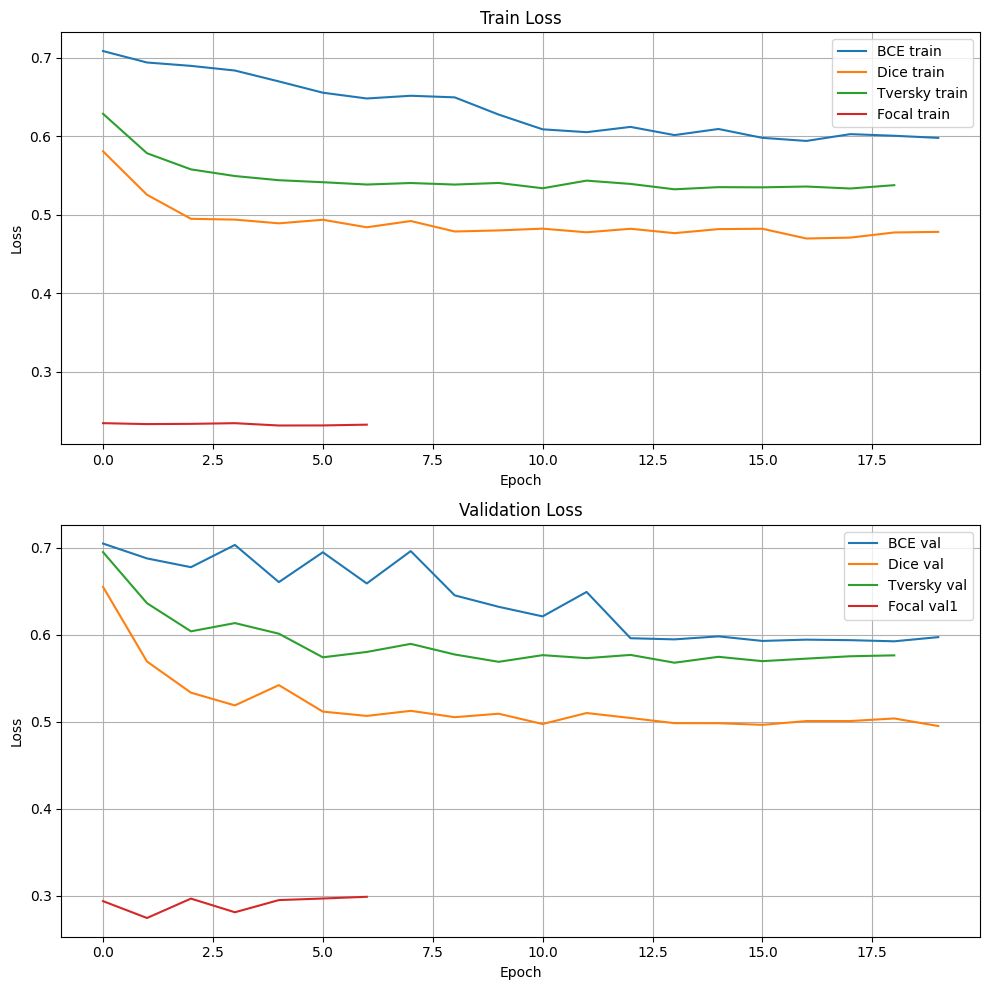

In [ ]:
plt.figure(figsize=(10, 10))

# train losse
plt.subplot(2, 1, 1)
plt.plot(loss_bce_train, label="BCE train")
plt.plot(loss_dice_train, label="Dice train")
plt.plot(loss_tversky_train, label="Tversky train")
plt.plot(loss_focal_train1, label="Focal train")
plt.title("Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

# val losses
plt.subplot(2, 1, 2)
plt.plot(loss_bce_val, label="BCE val")
plt.plot(loss_dice_val, label="Dice val")
plt.plot(loss_tversky_val, label="Tversky val")
plt.plot(loss_focal_val1, label="Focal val1")
plt.title("Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
def test(model, loader, loss_fn, device):
    model.eval()
    total_loss = 0.0
    total_iou = 0.0
    n = 0

    with torch.no_grad():
        for X, Y in loader:
            X = X.float().to(device)
            Y = Y.float().to(device)

            pred = model(X)

            loss = loss_fn(pred, Y).item()
            total_loss += loss

            iou = iou_score(pred, Y.int()).item()
            total_iou += iou

            n += 1

    return total_loss / n, total_iou / n


In [ ]:
test_loss_bce, iou_bce = test(model_bce, test_dataloader,loss_bce, device)
iou_bce

0.7222835971758916

In [ ]:
test_loss_dic, iou_dice = test(model_dice, test_dataloader, loss_dice, device)
test_loss_dice

0.43801770301965565

In [ ]:
test_loss_focal, iou_focal = test(model_focal, test_dataloader, loss_focal1, device)
test_loss_focal

0.21833278582646296

In [ ]:
test_loss_tversky, iou_tversky = test(model_tversky, test_dataloader, loss_tversky, device)
test_loss_tversky

0.494287541279426

In [ ]:
print("SegNet Evaluation Summary")
print(f"{'Test Loss':<12}")
print("")
print(f"{'BCE'}   {test_loss_bce:.6f} {iou_bce:.6f}")
print(f"{'Dice'}  {test_loss_dice:.6f} {iou_dice:.6f}")
print(f"{'Focal'} {test_loss_focal:.6f} {iou_focal:.6f}")
print(f"{'Tversky'} {test_loss_tversky:.6f} {iou_tversky:.6f}")



SegNet Evaluation Summary
Test Loss   

BCE   0.369907 0.722284
Dice  0.438018 0.788998
Focal 0.218333 0.231133
Tversky 0.494288 0.791876


При каком лоссе модель сходится быстрее?
При каком лоссе модель выдает наилучшую метрику?
Напишите развернутый ответ на вопросы.

Быстрее всего модель сходится при Focal Loss, сразу падает на низкие значения и стабильно уменьшаются уже к 3-4 эпохе.
BCE обучается намного медленнее всех и остаётся выше. Тверский и Dice рядом друг с другом, незначительно отличаются

Лучшие результаты на тесте даёт Focal Loss. У него самые низкие значения валидационного лосса, IoU и меньше колебаний

# Задание: Новая модель!

## Модель U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

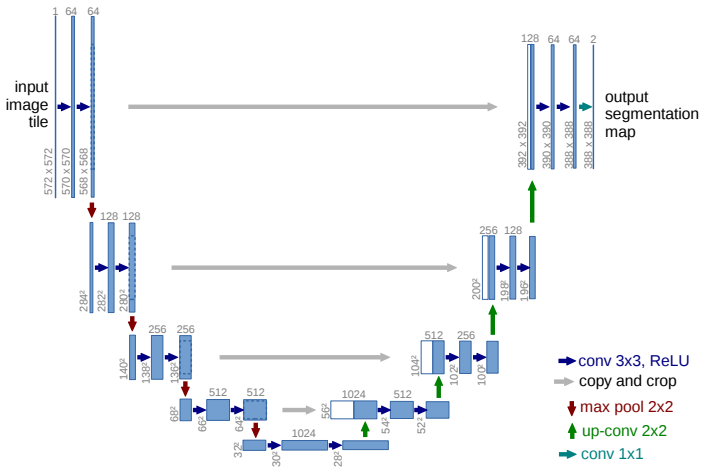

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

В оригинальной статье авторы не использовали padding внутри модели (это видно по тому, что размеры карты признаков уменьшаются на 2 каждый раз при движении от слоя к слою). При этом размеры входных изображений авторы единоразово увеличили при помощи mirror padding.

В этом домашнем задании вы можете применить альтернативный подход - сохранять размеры карт признаков при помощью padding = 1 во внутренних слоях.  

In [ ]:
import torch.nn.functional as F
import torch.nn as nn

Для реализации UNet вы можете написать классы блоков энкодера и декодера отдельно, как мы сделали при реализации SegNet.

In [ ]:
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, depth, kernel_size = 3, padding = 1, do_pool=True):
        super(EncoderBlock, self).__init__()
        self.layers = nn.ModuleList()

        self.do_pool = do_pool

        self.layers.append(nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = kernel_size, padding = padding))
        self.layers.append(nn.BatchNorm2d(out_channels))
        self.layers.append(nn.ReLU(inplace=True))

        for i in range(depth-1):
            self.layers.append(nn.Conv2d(in_channels = out_channels, out_channels = out_channels, kernel_size = kernel_size, padding = padding))
            self.layers.append(nn.BatchNorm2d(out_channels))
            self.layers.append(nn.ReLU(inplace=True))

        self.maxpooling = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        skip = x.clone()
        if self.do_pool:
            x = self.maxpooling(x)
        return x, skip

In [ ]:
class DecoderBlock(nn.Module):
  def __init__(self, in_channels, out_channels, skip_channels, depth, kernel_size = 3, padding = 1) -> None:
      super(DecoderBlock, self).__init__()
      self.layers = nn.ModuleList()

      self.upconv = nn.ConvTranspose2d(in_channels = in_channels, out_channels = out_channels, kernel_size = 2, stride = 2, padding = 0)

      self.layers.append(nn.Conv2d(in_channels = out_channels+skip_channels, out_channels = out_channels, kernel_size = kernel_size, padding = padding))
      self.layers.append(nn.BatchNorm2d(out_channels))
      self.layers.append(nn.ReLU(inplace=True))

      for i in range(depth-1):
          self.layers.append(nn.Conv2d(in_channels = out_channels, out_channels = out_channels, kernel_size = kernel_size, padding = padding))
          self.layers.append(nn.BatchNorm2d(out_channels))
          self.layers.append(nn.ReLU(inplace=True))

  def forward(self,x,skip):
    up_x = self.upconv(x)
    x = torch.cat([up_x, skip], dim=1)
    for layer in self.layers:
        x = layer(x)
    return x



In [ ]:
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels = 1, num_features = 64, n_class=1):
        super().__init__()
        self.encoder0 = EncoderBlock(in_channels, num_features, depth=3)
        self.encoder1 = EncoderBlock(num_features, num_features * 2, depth=3)
        self.encoder2 = EncoderBlock(num_features*2, num_features*4,depth=3)
        self.encoder3 = EncoderBlock(num_features*4, num_features*8, depth=3)

        #encoder bottleneck
        self.encoder4 = EncoderBlock(num_features*8, num_features*16, depth=3, do_pool=False)

        self.decoder1 = DecoderBlock(num_features * 16, num_features * 8, skip_channels=num_features * 8, depth=2)
        self.decoder2 = DecoderBlock(num_features * 8, num_features * 4,  skip_channels=num_features * 4, depth=2)
        self.decoder3 = DecoderBlock(num_features * 4, num_features * 2,  skip_channels=num_features * 2, depth=2)
        self.decoder4 = DecoderBlock(num_features * 2, num_features,      skip_channels=num_features,     depth=2)

        self.out_conv = nn.Conv2d(num_features, out_channels, kernel_size=1)


    def forward(self, x):
        x, skip0 = self.encoder0(x)
        x, skip1 = self.encoder1(x)
        x, skip2 = self.encoder2(x)
        x, skip3 = self.encoder3(x)
        x, _ = self.encoder4(x)

        x = self.decoder1(x,skip3)
        x = self.decoder2(x,skip2)
        x = self.decoder3(x,skip1)
        x = self.decoder4(x,skip0)

        output = self.out_conv(x)


        return output

In [ ]:
model = UNet()
x = torch.randn(1, 3, 256, 256)
y = model(x)
print(y.shape)


torch.Size([1, 1, 256, 256])


In [ ]:
unet_model = UNet().to(device)

## Обучите UNet

Задание: обучите UNet на всех трех лоссах: BCE, Dice, Focal и сравните результаты с SegNet:
*   Какая модель дает лучшие значения по метрике?
*   Какая модель дает лучшие значения по лоссам?
*   Какая модель обучается быстрее?
*   Сравните визуально результаты SegNet и UNet.

Напишите развернутый ответ на вопросы.



In [ ]:
unet_bce_loss = nn.BCEWithLogitsLoss()

def unet_dice_loss(y_pred, y_real, eps=1e-7):
    y_pred = torch.sigmoid(y_pred)
    intersection = (y_pred * y_real).sum(dim=(1,2,3))
    union = y_pred.sum(dim=(1,2,3)) + y_real.sum(dim=(1,2,3))
    dice = (2 * intersection + eps) / (union + eps)
    return 1 - dice.mean()

def unet_focal_loss(y_pred, y_real, alpha=0.8, gamma=2.0, eps=1e-7):
    bce = nn.functional.binary_cross_entropy_with_logits(
        y_pred, y_real, reduction="none"
    )
    pt = torch.exp(-bce)
    focal = alpha * (1 - pt)**gamma * bce
    return focal.mean()


In [ ]:
model_unet_bce = UNet().to(device)
opt = torch.optim.Adam(model_unet_bce.parameters(), lr=1e-4)

train_bce, val_bce = train(
    model_unet_bce, opt, unet_bce_loss,
    epochs=20,
    train_loader=train_dataloader,
    val_loader=valid_dataloader,
    device=device,
    checkpoint_path="unet_best_bce.pth"
)



 Epoch 1/20


Training Epoch 1:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.4324
Val loss: 0.4908
new best model saved (loss=0.4908)

 Epoch 2/20


Training Epoch 2:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.3272
Val loss: 0.2631
new best model saved (loss=0.2631)

 Epoch 3/20


Training Epoch 3:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.2996
Val loss: 0.2554
new best model saved (loss=0.2554)

 Epoch 4/20


Training Epoch 4:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.2749
Val loss: 0.3797
no improvement (1/5)

 Epoch 5/20


Training Epoch 5:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.2879
Val loss: 0.2630
no improvement (2/5)

 Epoch 6/20


Training Epoch 6:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.2746
Val loss: 0.2404
new best model saved (loss=0.2404)

 Epoch 7/20


Training Epoch 7:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.2543
Val loss: 0.2181
new best model saved (loss=0.2181)

 Epoch 8/20


Training Epoch 8:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.2487
Val loss: 0.2042
new best model saved (loss=0.2042)

 Epoch 9/20


Training Epoch 9:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.2366
Val loss: 0.1759
new best model saved (loss=0.1759)

 Epoch 10/20


Training Epoch 10:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.2389
Val loss: 0.1954
no improvement (1/5)

 Epoch 11/20


Training Epoch 11:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.2407
Val loss: 0.2087
no improvement (2/5)

 Epoch 12/20


Training Epoch 12:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.2123
Val loss: 0.2449
no improvement (3/5)

 Epoch 13/20


Training Epoch 13:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.2229
Val loss: 0.1889
no improvement (4/5)

 Epoch 14/20


Training Epoch 14:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.2346
Val loss: 0.1639
new best model saved (loss=0.1639)

 Epoch 15/20


Training Epoch 15:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.2087
Val loss: 0.1415
new best model saved (loss=0.1415)

 Epoch 16/20


Training Epoch 16:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.2210
Val loss: 0.1664
no improvement (1/5)

 Epoch 17/20


Training Epoch 17:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.2202
Val loss: 0.1513
no improvement (2/5)

 Epoch 18/20


Training Epoch 18:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.2335
Val loss: 0.2453
no improvement (3/5)

 Epoch 19/20


Training Epoch 19:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.2035
Val loss: 0.1493
no improvement (4/5)

 Epoch 20/20


Training Epoch 20:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.1976
Val loss: 0.1308
new best model saved (loss=0.1308)


In [ ]:
model_unet_dice = UNet().to(device)
opt = torch.optim.Adam(model_unet_dice.parameters(), lr=1e-4)
train_unet_dice, val_unet_dice = train(
    model_unet_dice, opt, unet_dice_loss,
    epochs=20,
    train_loader=train_dataloader,
    val_loader=valid_dataloader,
    device=device,
    checkpoint_path="unet_best_dice.pth"
)


 Epoch 1/20


Training Epoch 1:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.4737
Val loss: 0.6404
new best model saved (loss=0.6404)

 Epoch 2/20


Training Epoch 2:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.3733
Val loss: 0.3832
new best model saved (loss=0.3832)

 Epoch 3/20


Training Epoch 3:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.3562
Val loss: 0.3488
new best model saved (loss=0.3488)

 Epoch 4/20


Training Epoch 4:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.3486
Val loss: 0.3113
new best model saved (loss=0.3113)

 Epoch 5/20


Training Epoch 5:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.3361
Val loss: 0.3094
new best model saved (loss=0.3094)

 Epoch 6/20


Training Epoch 6:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.3324
Val loss: 0.3256
no improvement (1/5)

 Epoch 7/20


Training Epoch 7:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.3130
Val loss: 0.3192
no improvement (2/5)

 Epoch 8/20


Training Epoch 8:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.3166
Val loss: 0.3173
no improvement (3/5)

 Epoch 9/20


Training Epoch 9:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.2992
Val loss: 0.3186
no improvement (4/5)

 Epoch 10/20


Training Epoch 10:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.2915
Val loss: 0.2760
new best model saved (loss=0.2760)

 Epoch 11/20


Training Epoch 11:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.2961
Val loss: 0.2841
no improvement (1/5)

 Epoch 12/20


Training Epoch 12:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.2732
Val loss: 0.2523
new best model saved (loss=0.2523)

 Epoch 13/20


Training Epoch 13:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.2731
Val loss: 0.2667
no improvement (1/5)

 Epoch 14/20


Training Epoch 14:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.2653
Val loss: 0.2223
new best model saved (loss=0.2223)

 Epoch 15/20


Training Epoch 15:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.2533
Val loss: 0.2826
no improvement (1/5)

 Epoch 16/20


Training Epoch 16:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.2575
Val loss: 0.2697
no improvement (2/5)

 Epoch 17/20


Training Epoch 17:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.2431
Val loss: 0.2436
no improvement (3/5)

 Epoch 18/20


Training Epoch 18:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.2292
Val loss: 0.2350
no improvement (4/5)

 Epoch 19/20


Training Epoch 19:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.2248
Val loss: 0.2643
no improvement (5/5)

early stopping after 19 epochs.


In [ ]:
model_unet_focal = UNet().to(device)
opt = torch.optim.Adam(model_unet_focal.parameters(), lr=1e-4)

train_unet_focal, val_unet_focal = train(
    model_unet_focal, opt, unet_focal_loss,
    epochs=20,
    train_loader=train_dataloader,
    val_loader=valid_dataloader,
    device=device,
    checkpoint_path="unet_best_focal.pth"
)



 Epoch 1/20


Training Epoch 1:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.1011
Val loss: 0.0983
new best model saved (loss=0.0983)

 Epoch 2/20


Training Epoch 2:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.0630
Val loss: 0.1123
no improvement (1/5)

 Epoch 3/20


Training Epoch 3:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.0573
Val loss: 0.0543
new best model saved (loss=0.0543)

 Epoch 4/20


Training Epoch 4:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.0522
Val loss: 0.0453
new best model saved (loss=0.0453)

 Epoch 5/20


Training Epoch 5:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.0547
Val loss: 0.0542
no improvement (1/5)

 Epoch 6/20


Training Epoch 6:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.0470
Val loss: 0.0418
new best model saved (loss=0.0418)

 Epoch 7/20


Training Epoch 7:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.0480
Val loss: 0.0440
no improvement (1/5)

 Epoch 8/20


Training Epoch 8:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.0486
Val loss: 0.0408
new best model saved (loss=0.0408)

 Epoch 9/20


Training Epoch 9:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.0453
Val loss: 0.0435
no improvement (1/5)

 Epoch 10/20


Training Epoch 10:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.0459
Val loss: 0.0379
new best model saved (loss=0.0379)

 Epoch 11/20


Training Epoch 11:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.0470
Val loss: 0.0438
no improvement (1/5)

 Epoch 12/20


Training Epoch 12:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.0453
Val loss: 0.0573
no improvement (2/5)

 Epoch 13/20


Training Epoch 13:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.0408
Val loss: 0.0428
no improvement (3/5)

 Epoch 14/20


Training Epoch 14:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.0473
Val loss: 0.0355
new best model saved (loss=0.0355)

 Epoch 15/20


Training Epoch 15:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.0444
Val loss: 0.0300
new best model saved (loss=0.0300)

 Epoch 16/20


Training Epoch 16:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.0359
Val loss: 0.0438
no improvement (1/5)

 Epoch 17/20


Training Epoch 17:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.0400
Val loss: 0.0259
new best model saved (loss=0.0259)

 Epoch 18/20


Training Epoch 18:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.0371
Val loss: 0.0395
no improvement (1/5)

 Epoch 19/20


Training Epoch 19:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.0386
Val loss: 0.0278
no improvement (2/5)

 Epoch 20/20


Training Epoch 20:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.0386
Val loss: 0.0224
new best model saved (loss=0.0224)


In [ ]:
import matplotlib.pyplot as plt

def plot_unet_loss(train_loss, val_loss, title="UNet Loss Convergence"):
    plt.figure(figsize=(8,5))
    plt.plot(train_loss, label="Train Loss", linewidth=2)
    plt.plot(val_loss, label="Val Loss", linewidth=2)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()


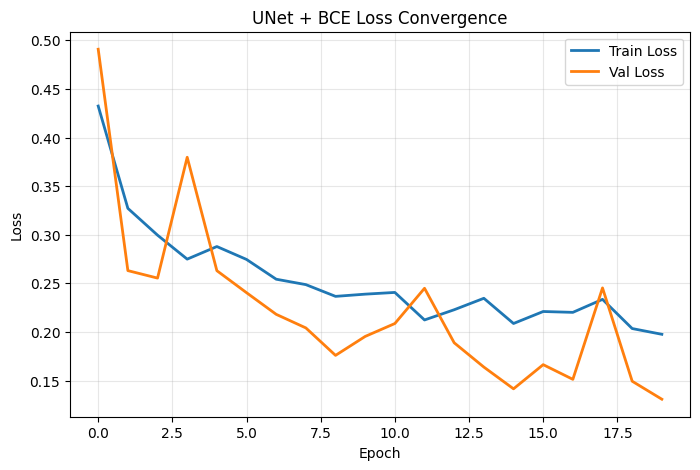

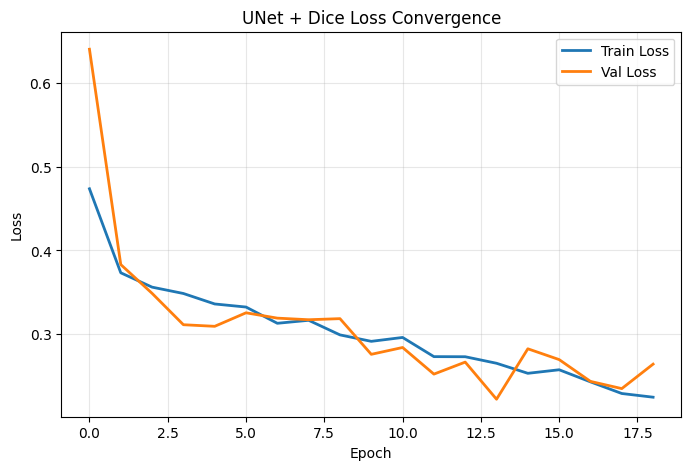

In [ ]:
plot_unet_loss(train_bce, val_bce,
               title="UNet + BCE Loss Convergence")

plot_unet_loss(train_unet_dice, val_unet_dice,
               title="UNet + Dice Loss Convergence")


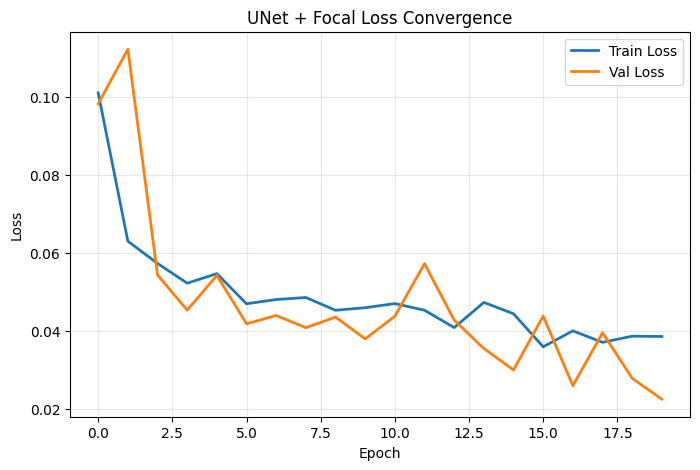

In [ ]:
plot_unet_loss(train_unet_focal, val_unet_focal,
               title="UNet + Focal Loss Convergence")


In [ ]:
loss_unet_bce, iou_unet_bce = test(model_unet_bce, test_dataloader, unet_bce_loss, device)


In [ ]:
loss_unet_dice, iou_unet_dice = test(
    model_unet_dice,
    test_dataloader,
    unet_dice_loss,
    device
)


In [ ]:
loss_unet_focal, iou_unet_focal = test(
    model_unet_focal,
    test_dataloader,
    unet_focal_loss,
    device
)


In [ ]:
print("UNet Evaluation Summary ")
print(f" {'Test Loss':<12} {'Test IoU':<12}")
print("")
print(f"{'BCE'}   {loss_unet_bce:.6f}   {iou_unet_bce:.6f}")
print(f"{'Dice'}  {loss_unet_dice:.6f}   {iou_unet_dice:.6f}")
print(f"{'Focal'} {loss_unet_focal:.6f}   {iou_unet_focal:.6f}")



UNet Evaluation Summary 
 Test Loss    Test IoU    

BCE   0.215515   0.798999
Dice  0.257280   0.798891
Focal 0.039851   0.808246


Итоги

Наилучший IoU показывает UNet + Focal.
Это объясняется тем, что UNet использует skip connections, позволяющие лучше восстанавливать границы объектов.
Focal снижает вклад легко классифицируемых пикселей и фокусируется на сложных. это стабилизирует обучение.
UNet с Dice Loss имеет лучшую сходимость по сравнению с BCE и Focal, train loss и val loss убывают более стабильно